<a href="https://colab.research.google.com/github/Glasiermedic/boston_marathon/blob/master/Boston_Race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://colab.research.google.com/drive/1D2XpWqykCmgpuem2vBgqMQ5R1Tv-atnQ

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.cluster import AffinityPropagation

from sklearn.cluster import SpectralClustering

from sklearn.cluster import DBSCAN


In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')

In [0]:
data = data.drop(['division', 'genderdiv', 'name', 'bib', 'ctz','state'], axis = 1)

In [5]:
data.head()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,country,city,40k
0,17.37,47.67,M,47,85.25,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,82.43,F,33,138.95,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,45.80,M,41,80.60,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,82.43,F,24,140.58,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,46.37,M,40,81.23,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 15 columns):
10k         31984 non-null object
25k         31984 non-null object
gender      31984 non-null object
age         31984 non-null int64
official    31984 non-null float64
35k         31984 non-null object
overall     31984 non-null int64
pace        31984 non-null float64
30k         31984 non-null object
5k          31984 non-null object
half        31984 non-null object
20k         31984 non-null object
country     31984 non-null object
city        31983 non-null object
40k         31984 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 3.7+ MB


In [7]:
data['30k'].str.contains('-').sum()

40

In [8]:
data.loc[data['30k'].str.contains('-')].head()

,10k,25k,gender,age,official,35k,overall,pace,30k,5k,half,20k,country,city,40k
2968,42.37,106.72,M,49,182.07,-,2700,6.95,-,21.23,89.57,84.90,USA,Andover,171.75
3189,-,-,M,47,195.82,160.48,5463,7.48,-,-,-,-,USA,Atlanta,184.62
7272,45.37,114.37,M,48,204.40,-,7616,7.80,-,22.52,96.03,91.02,USA,Midland Park,191.60
7417,-,-,F,42,264.28,218.07,22540,10.08,-,-,-,-,CAN,Toronto,251.72
8211,44.82,116.15,M,63,209.98,170.18,9341,8.02,-,22.20,97.37,92.20,AUS,Adelaide,197.90


In [0]:
# Convert race times to numeric values.
columns = data[['5k','10k','20k','25k','half','30k','35k','40k','age','official','pace']]

for column in columns: 
    data[column] = pd.to_numeric(data[column], errors='coerce')

In [0]:
data_numeric = data.copy().select_dtypes(include='number')

In [0]:
gender = (data['gender'].values == 'F').astype('int')


In [0]:
data.country =data.country.astype('category')

In [0]:
data_numeric["country_cat"] = data["country"].cat.codes

In [0]:
data_numeric['percentile_official'] = data_numeric.official.rank(pct=True)*100

#### We are encoding female as "1" and male as "0"

In [0]:
data_numeric['gender'] = gender

In [16]:
data_numeric[:5]

,10k,25k,age,official,35k,overall,pace,30k,5k,half,20k,40k,country_cat,percentile_official,gender
0,17.37,47.67,47,85.25,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,41,0.025013,0
1,32.58,82.43,33,138.95,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,42,0.215733,1
2,16.62,45.80,41,80.60,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,59,0.003127,0
3,32.57,82.43,24,140.58,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,26,0.234492,1
4,17.12,46.37,40,81.23,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,41,0.007816,0


In [17]:
data_numeric.percentile_official.describe()

count    31984.000000
mean        50.001563
std         28.867964
min          0.003127
25%         25.005471
50%         50.003127
75%         74.998828
max        100.000000
Name: percentile_official, dtype: float64

In [0]:
data_numeric = data_numeric.dropna()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [20]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [21]:
data_scaled

array([[-3.9333155 , -3.35970124,  0.40841499, ..., -1.33387342,
        -1.72930403, -0.90009405],
       [-2.18703976, -2.00035288, -0.83056516, ..., -1.28154757,
        -1.72266076,  1.11099501],
       [-4.01942377, -3.43283074, -0.12257651, ..., -0.39200819,
        -1.73006637, -0.90009405],
       ...,
       [ 0.84626759,  0.91661472, -1.89254815, ...,  0.39287949,
         1.00826577,  1.11099501],
       [ 1.39161997,  1.33896692, -0.38807225, ...,  0.39287949,
         1.26784319,  1.11099501],
       [ 0.22973237,  0.05626766,  1.02790506, ...,  0.39287949,
        -0.10791169, -0.90009405]])

In [0]:
bandwidth = estimate_bandwidth(data_numeric, quantile=0.2, n_samples=500)

n_clusters=3

km = KMeans(n_clusters=4, random_state=1, init = 'k-means++')

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

#sc = SpectralClustering(n_clusters=n_clusters)

#af = AffinityPropagation(max_iter=20).fit(data_scaled)



In [23]:
km.fit(data_numeric)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

In [24]:
ms.fit(data_numeric)

MeanShift(bandwidth=3495.619988458853, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=None, seeds=None)

In [0]:
dbs = DBSCAN(eps=.01, metric= 'euclidean', min_samples=2).fit(data_scaled)



In [26]:
km.cluster_centers_

array([[5.35555731e+01, 1.37642315e+02, 4.53310956e+01, 2.49975863e+02,
        2.01906433e+02, 1.98517578e+04, 9.54249525e+00, 1.68721510e+02,
        2.67068018e+01, 1.14812669e+02, 1.08755975e+02, 2.35528345e+02,
        6.60378721e+01, 6.22334830e+01, 5.58201393e-01],
       [4.21137104e+01, 1.06174402e+02, 3.82073906e+01, 1.86234517e+02,
        1.52034429e+02, 3.93235282e+03, 7.11125943e+00, 1.28649438e+02,
        2.10853947e+01, 8.92864907e+01, 8.46374635e+01, 1.75736453e+02,
        6.48800905e+01, 1.24593562e+01, 1.87028658e-01],
       [6.27547701e+01, 1.68264841e+02, 4.35720091e+01, 3.13786271e+02,
        2.53285132e+02, 2.77859653e+04, 1.19762802e+01, 2.09358125e+02,
        3.09101245e+01, 1.38273978e+02, 1.30794843e+02, 2.96137464e+02,
        6.94251969e+01, 8.70402870e+01, 5.22098044e-01],
       [4.82077827e+01, 1.22587537e+02, 4.24649167e+01, 2.18520520e+02,
        1.77467929e+02, 1.19039435e+04, 8.34280919e+00, 1.49297328e+02,
        2.40660462e+01, 1.02745270e+0

In [27]:
km.labels_

array([1, 1, 1, ..., 2, 2, 3], dtype=int32)

In [28]:
ms.labels_

array([0, 0, 0, ..., 3, 3, 4])

In [29]:
dbs.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [0]:
data_numeric['km_labels'] = km.labels_

In [0]:
data_numeric['ms_labels'] = ms.labels_

In [0]:
data_numeric['dbs_labels'] = dbs.labels_

In [33]:
data_numeric['dbs_labels'].describe()

count    31649.000000
mean        -0.857468
std          2.510368
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         65.000000
Name: dbs_labels, dtype: float64

In [34]:
data_numeric.head()

,10k,25k,age,official,35k,overall,pace,30k,5k,half,20k,40k,country_cat,percentile_official,gender,km_labels,ms_labels,dbs_labels
0,17.37,47.67,47,85.25,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,41,0.025013,0,1,0,-1
1,32.58,82.43,33,138.95,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,42,0.215733,1,1,0,-1
2,16.62,45.80,41,80.60,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,59,0.003127,0,1,0,-1
3,32.57,82.43,24,140.58,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,26,0.234492,1,1,0,-1
4,17.12,46.37,40,81.23,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,41,0.007816,0,1,0,-1


In [35]:
data_numeric['km_labels'].value_counts()

1    7951
3    7922
0    7897
2    7879
Name: km_labels, dtype: int64

In [36]:
data_numeric.groupby('km_labels')['gender'].describe()


,count,mean,std,min,25%,50%,75%,max
km_labels,,,,,,,,
0,7897.0,0.557933,0.496664,0.0,0.0,1.0,1.0,1.0
1,7951.0,0.186895,0.389852,0.0,0.0,0.0,0.0,1.0
2,7879.0,0.522401,0.499530,0.0,0.0,1.0,1.0,1.0
3,7922.0,0.524741,0.499419,0.0,0.0,1.0,1.0,1.0


In [37]:
data_numeric.columns

Index(['10k', '25k', 'age', 'official', '35k', 'overall', 'pace', '30k', '5k',
       'half', '20k', '40k', 'country_cat', 'percentile_official', 'gender',
       'km_labels', 'ms_labels', 'dbs_labels'],
      dtype='object')

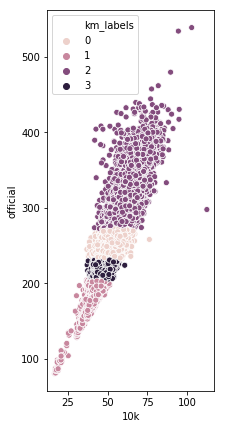

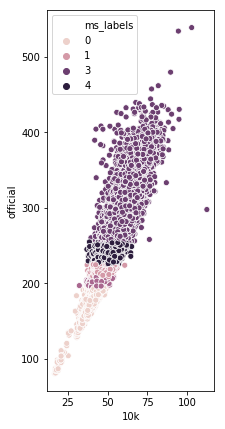

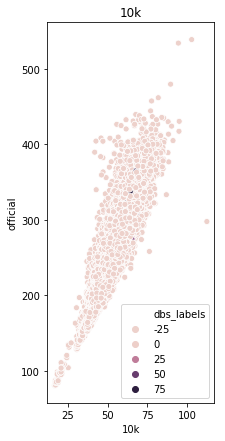

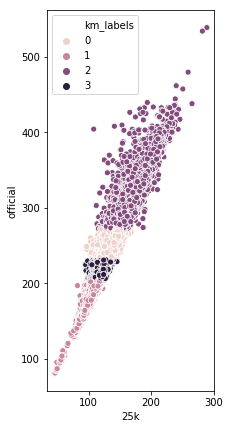

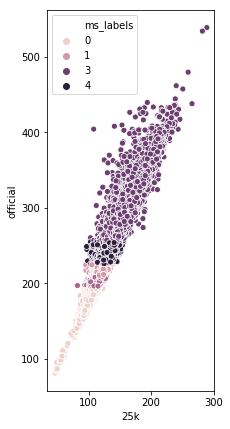

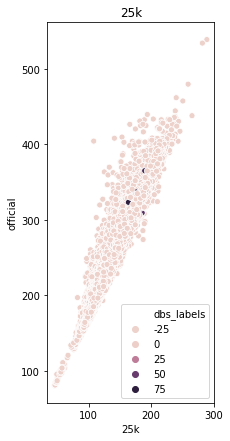

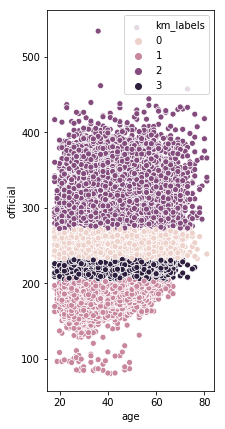

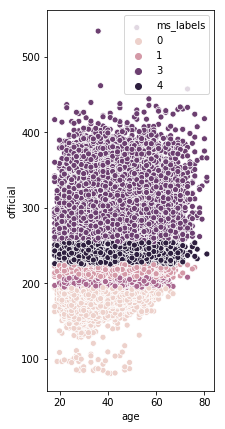

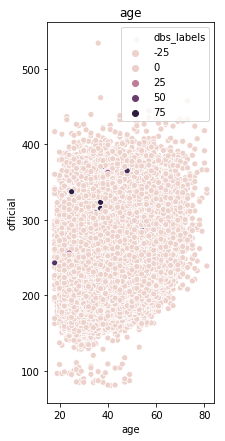

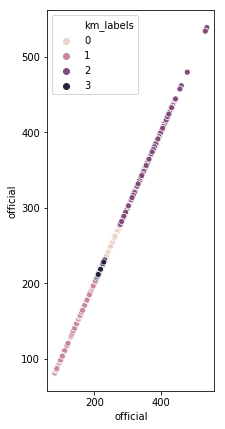

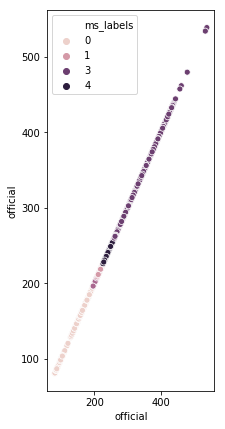

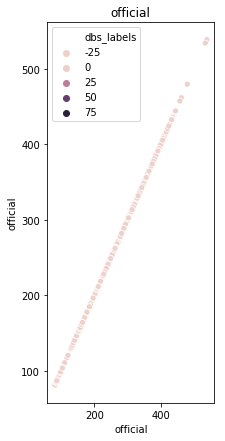

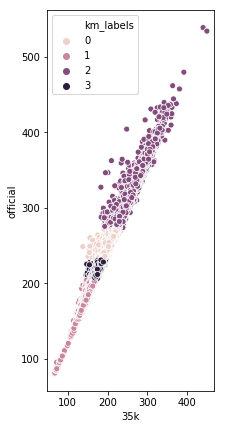

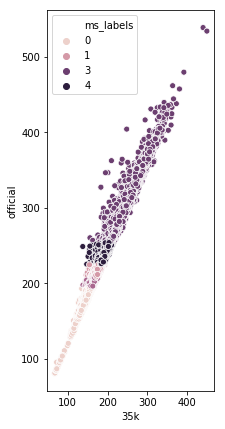

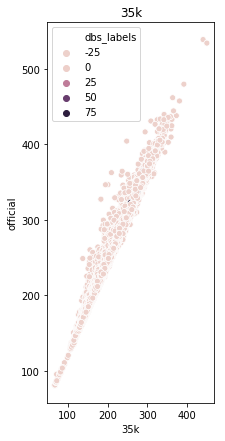

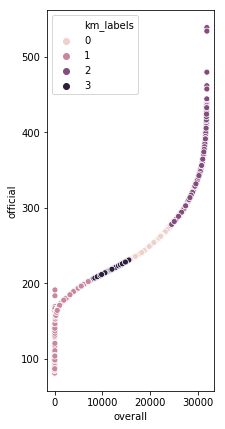

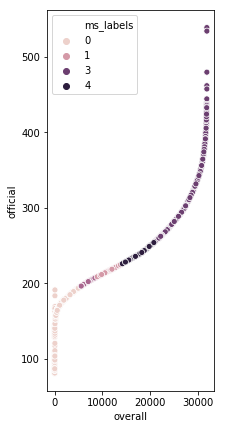

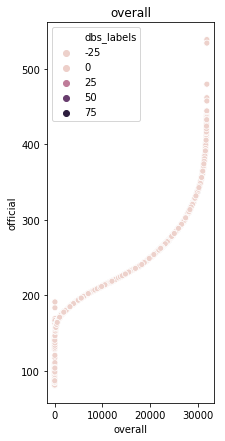

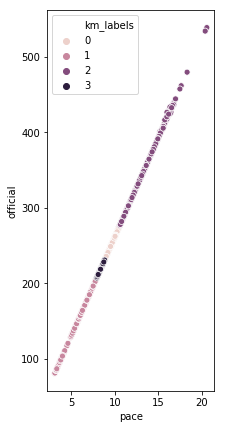

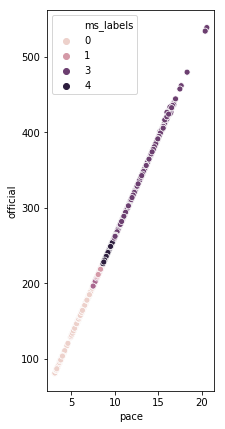

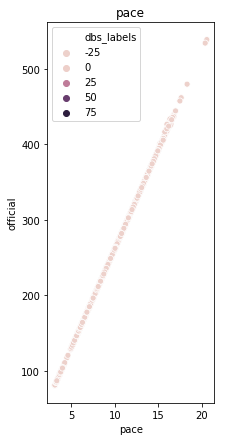

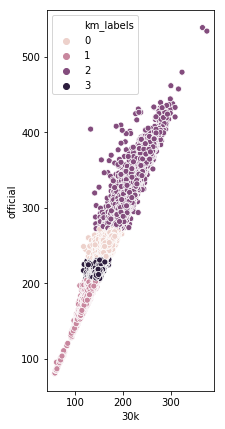

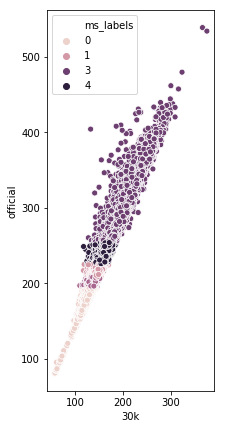

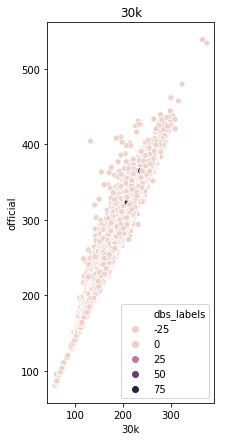

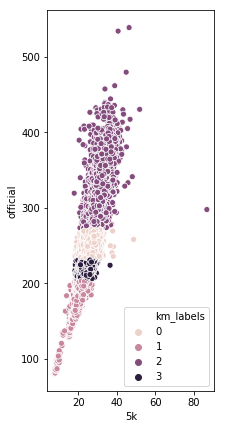

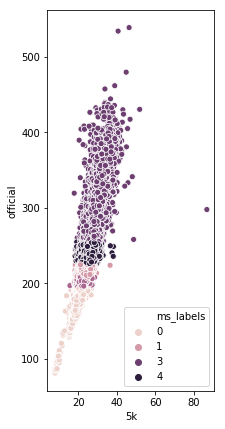

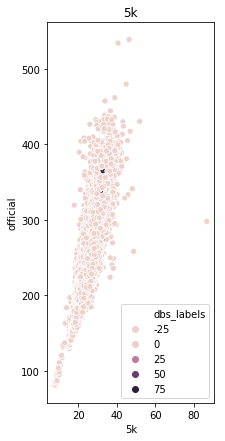

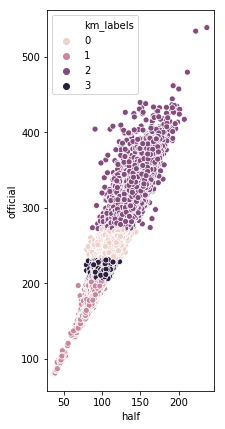

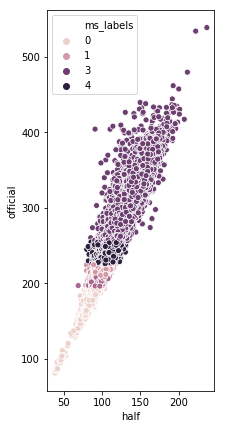

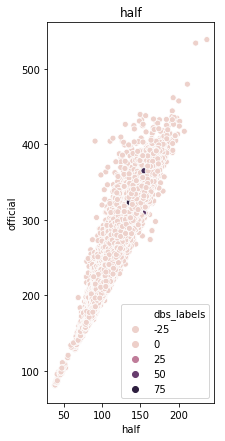

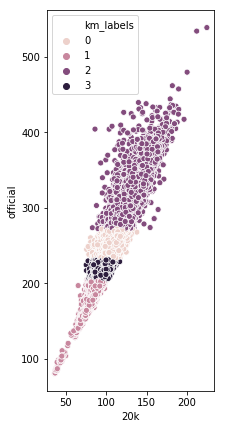

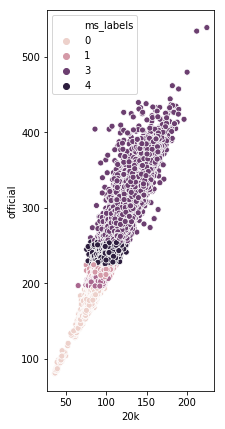

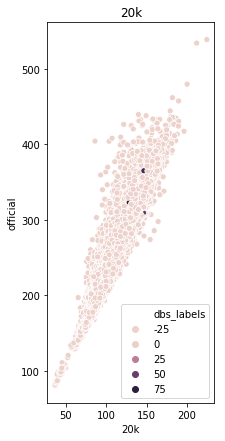

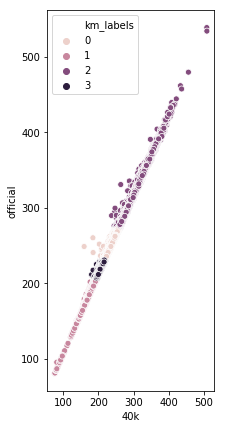

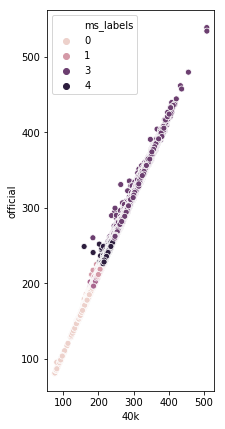

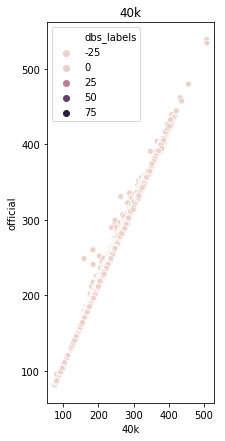

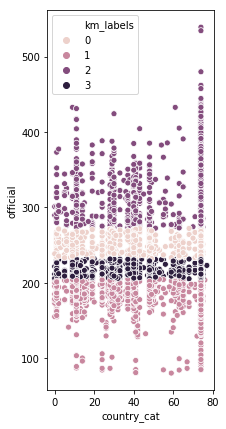

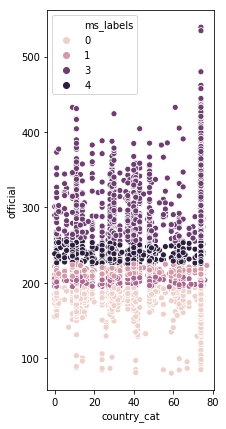

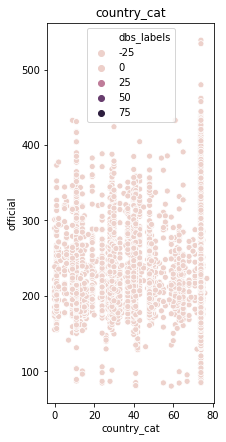

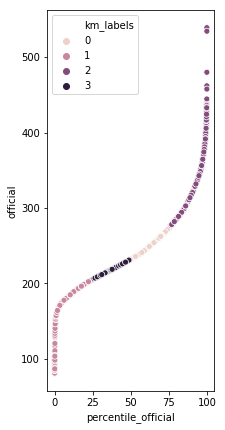

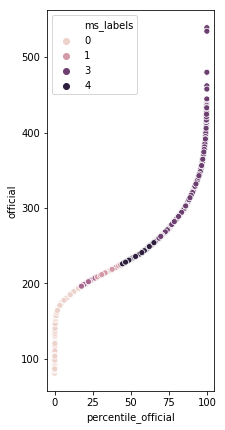

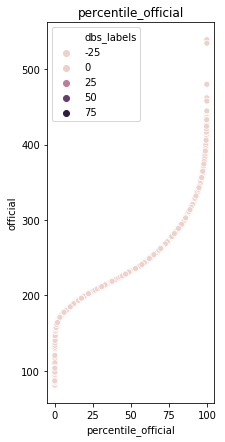

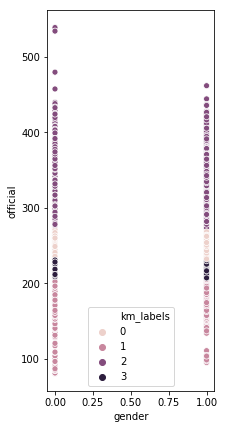

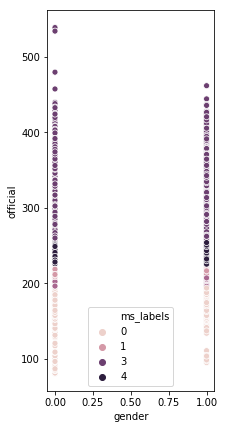

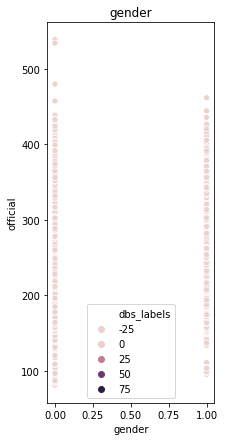

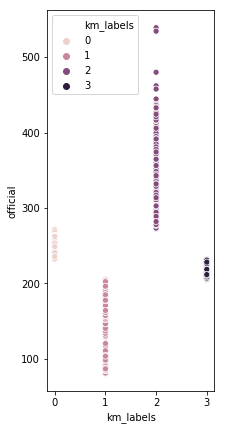

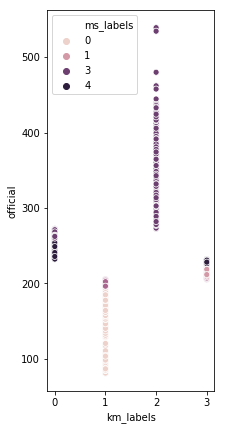

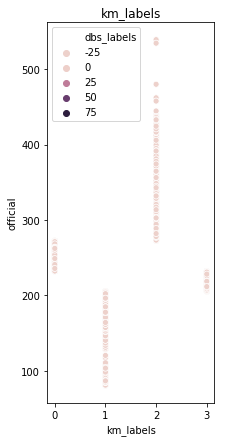

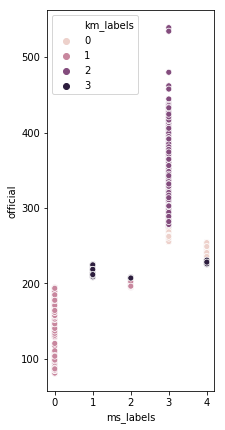

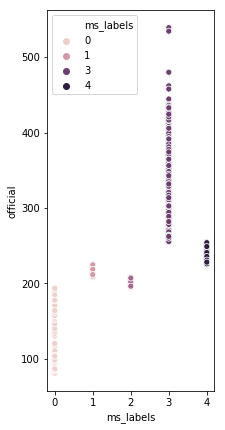

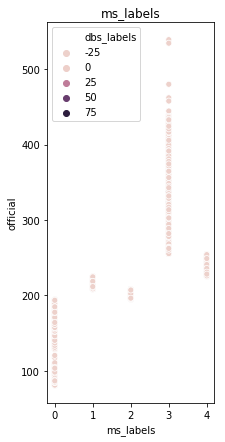

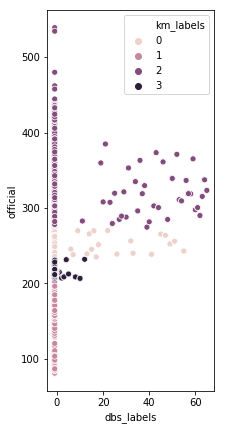

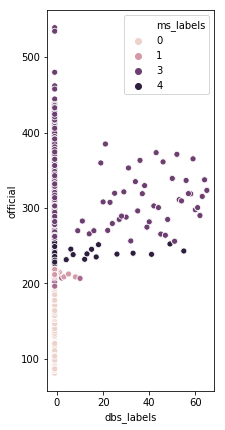

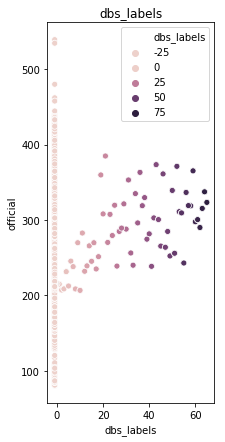

In [38]:
for col in data_numeric.columns:
  plt.figure(figsize=(3,7))
  sns.scatterplot(y =data_numeric.official, x = data_numeric[col], color="k", hue = 'km_labels', data = data_numeric)
  plt.show()
  plt.figure(figsize=(3,7))
  sns.scatterplot(y =data_numeric.official, x = data_numeric[col], color="k", hue = 'ms_labels', data = data_numeric)
  plt.show()
  plt.figure(figsize=(3,7))
  sns.scatterplot(y =data_numeric.official, x = data_numeric[col], color="k", hue = 'dbs_labels', data = data_numeric)
  plt.title(col)
  plt.show()

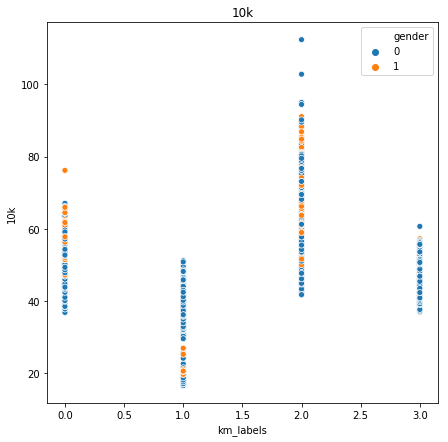

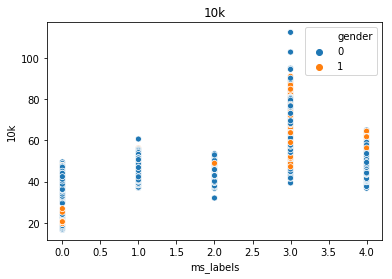

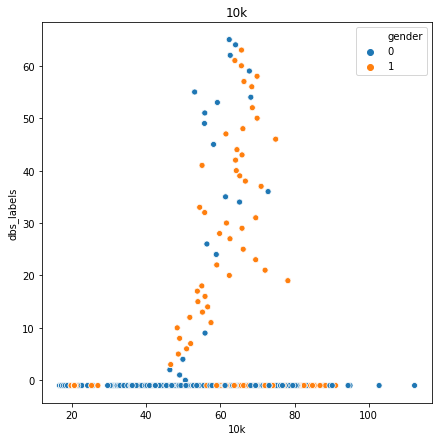

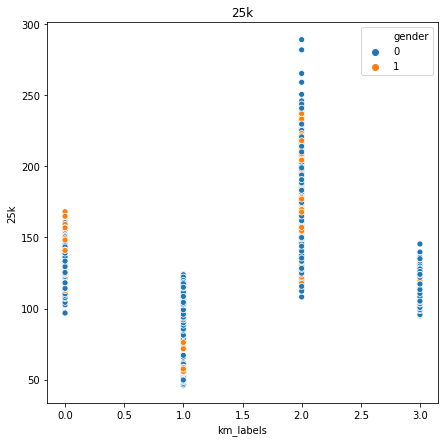

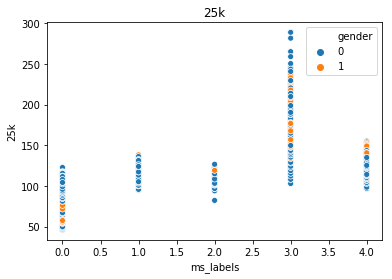

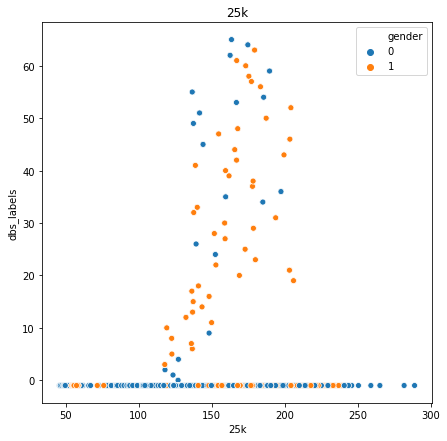

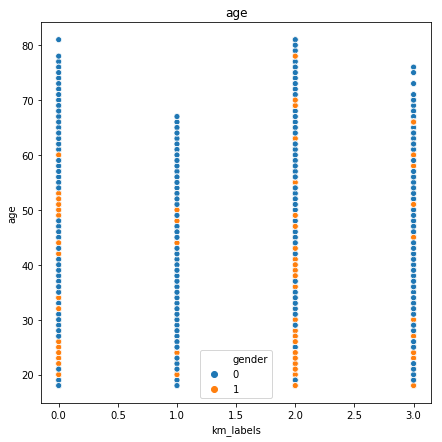

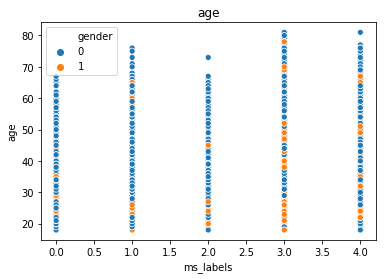

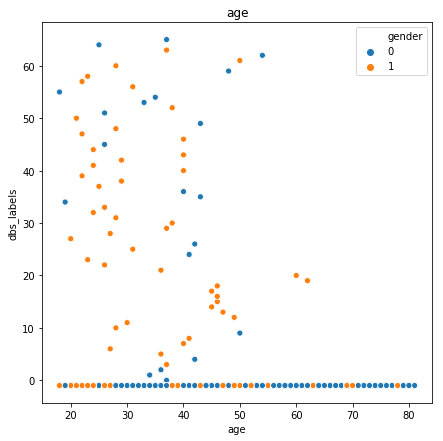

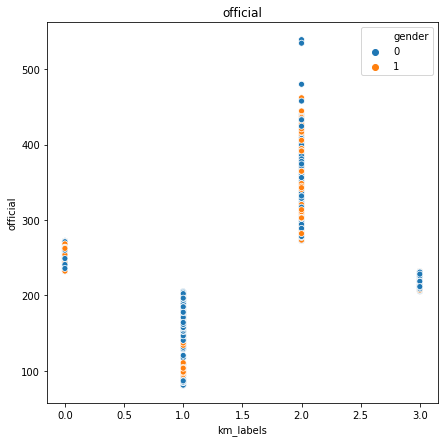

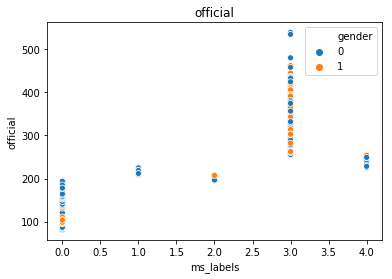

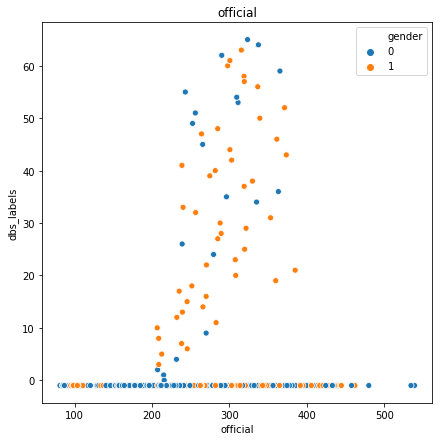

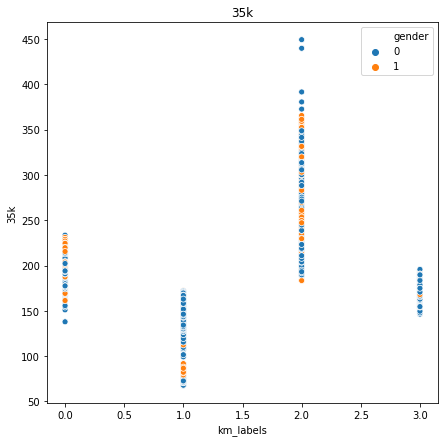

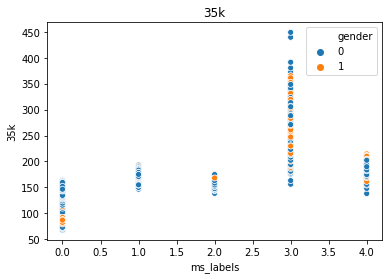

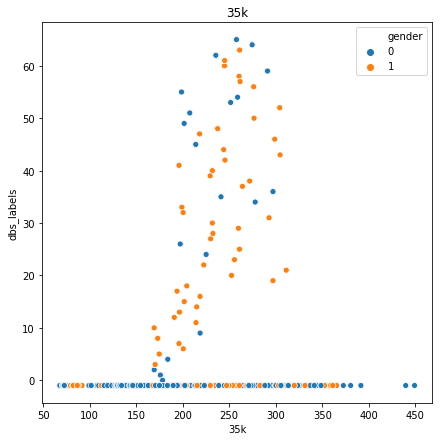

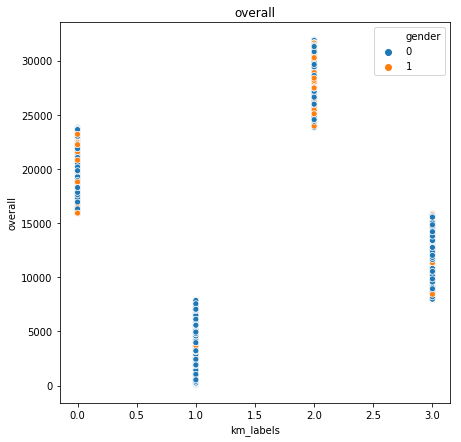

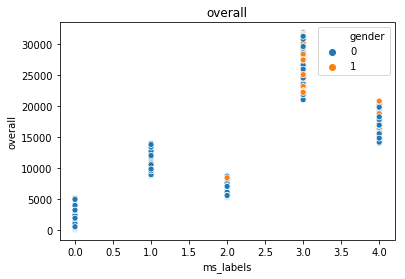

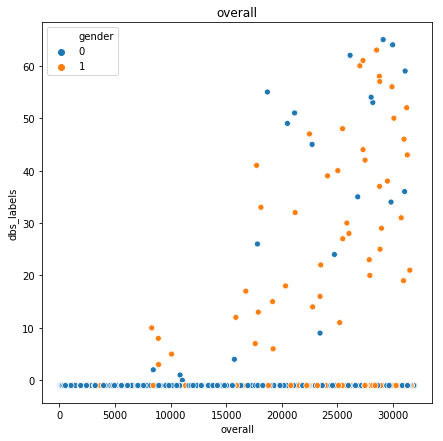

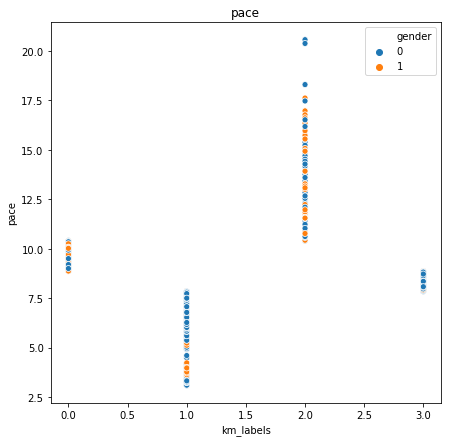

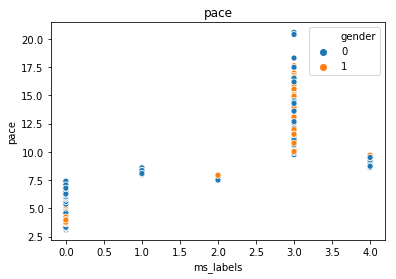

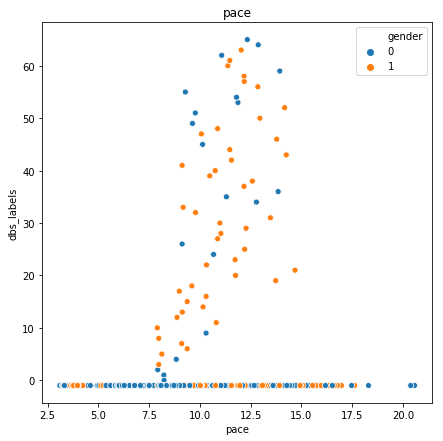

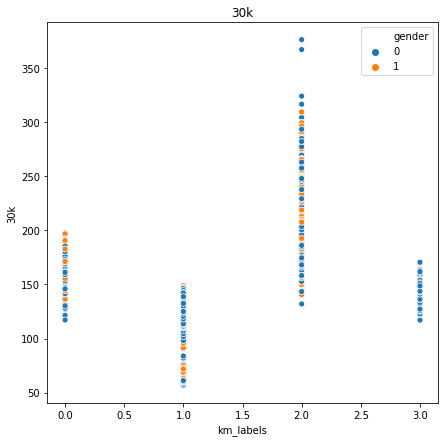

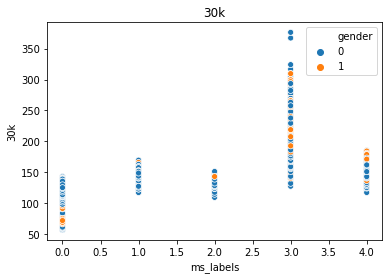

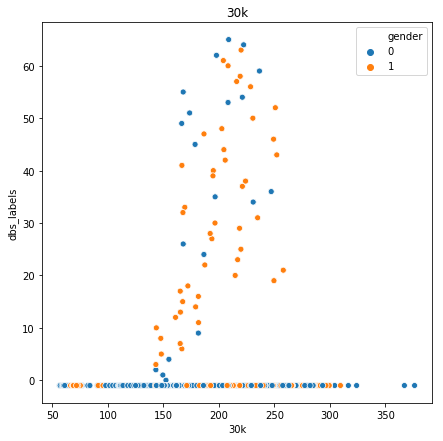

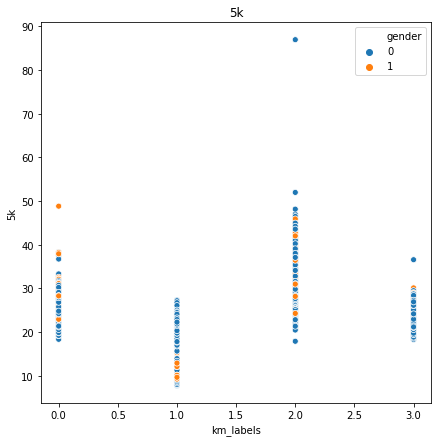

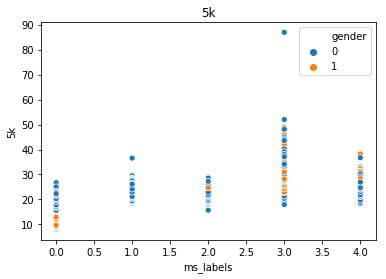

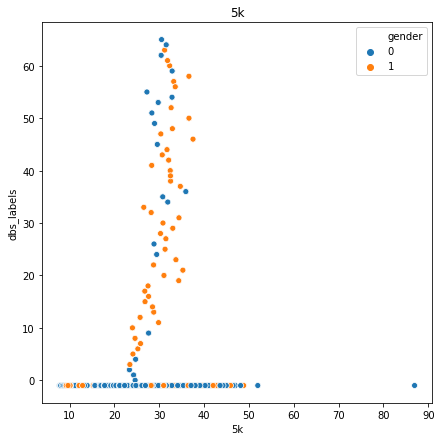

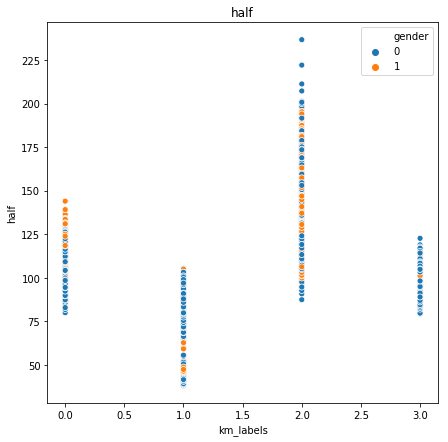

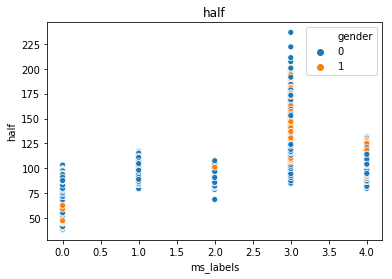

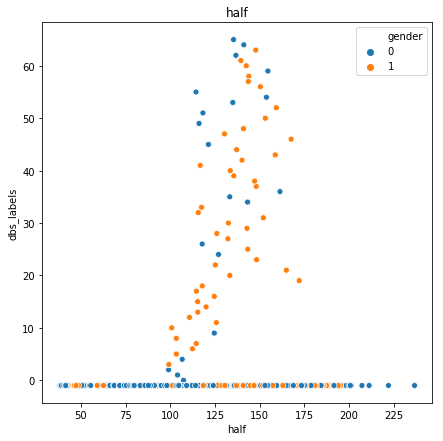

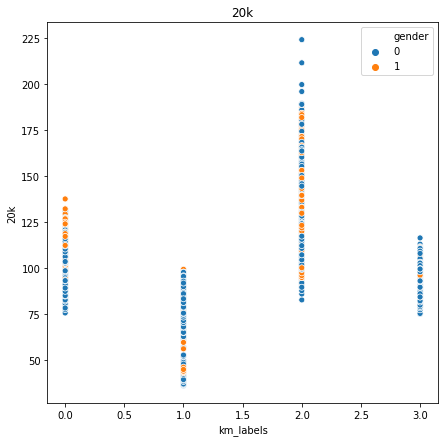

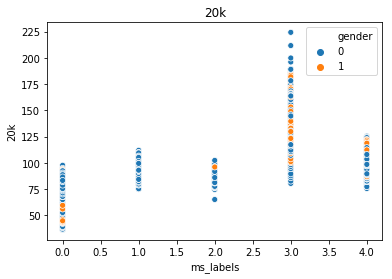

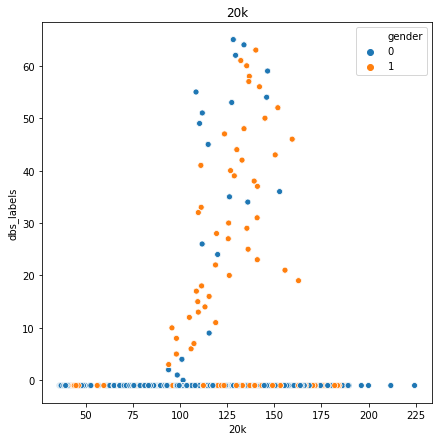

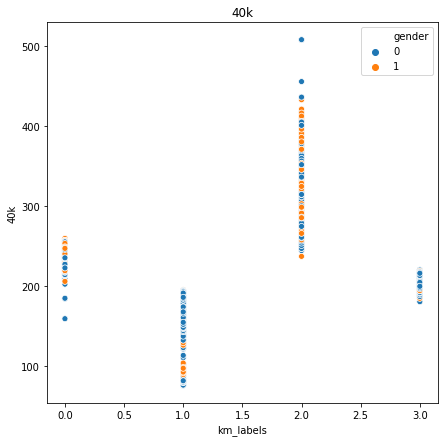

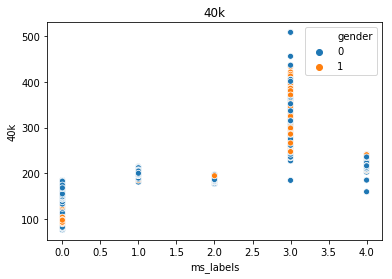

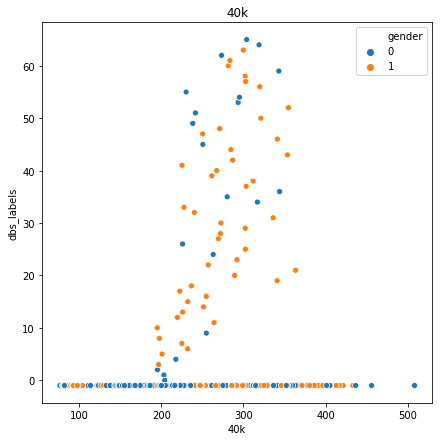

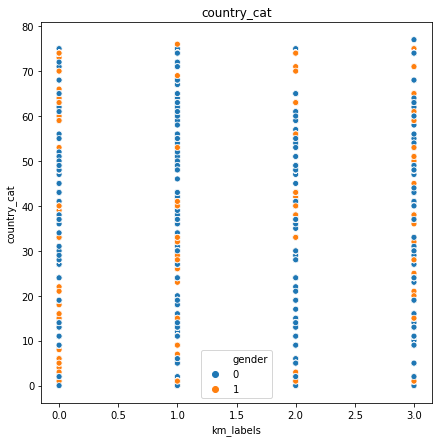

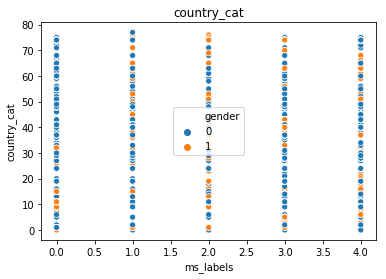

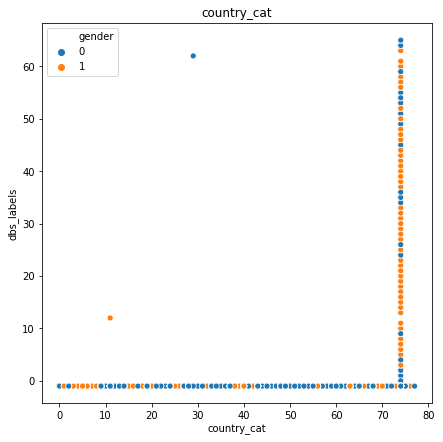

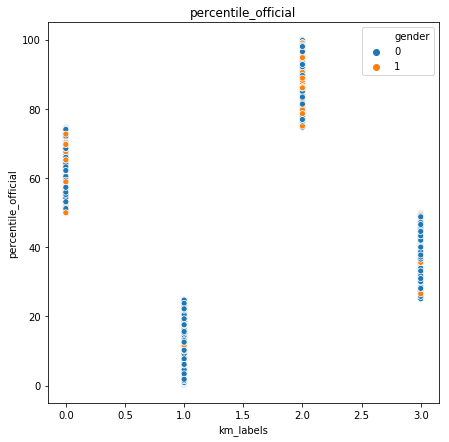

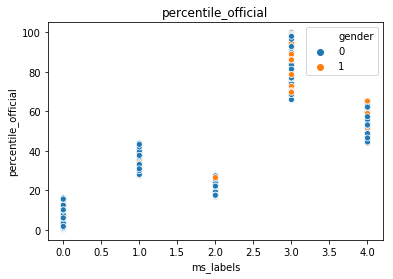

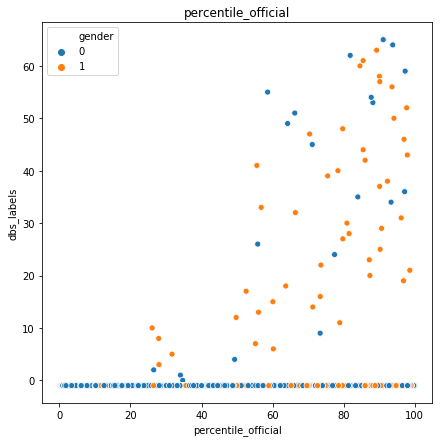

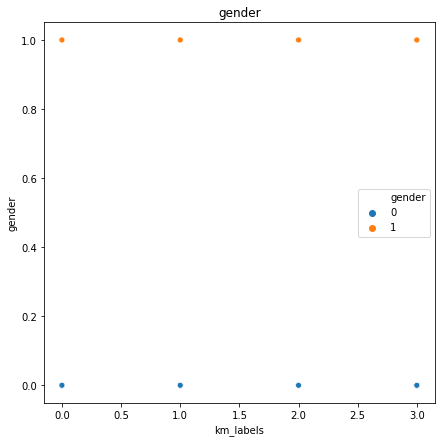

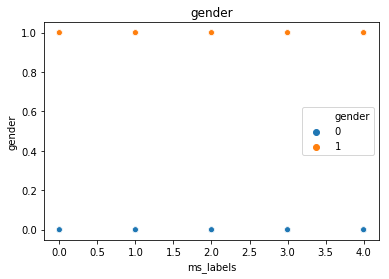

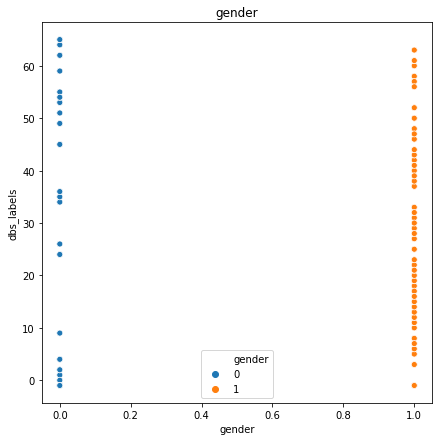

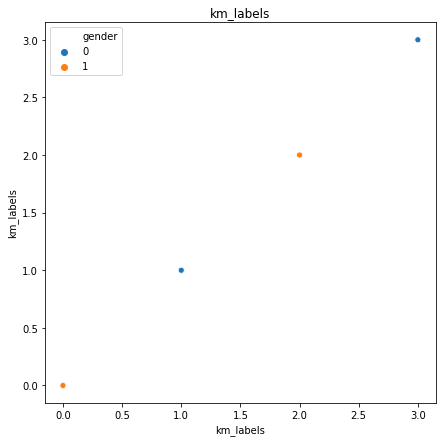

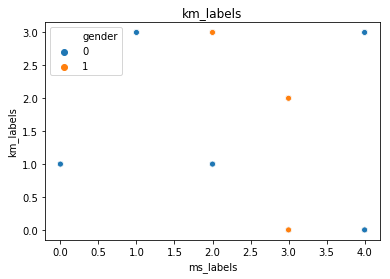

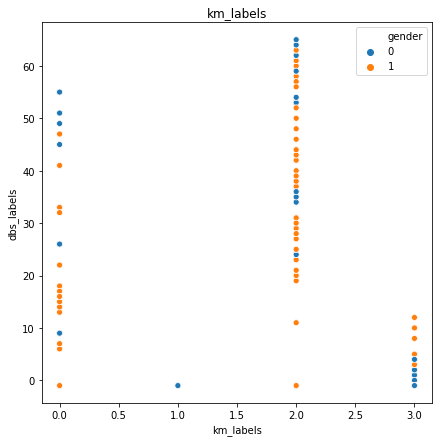

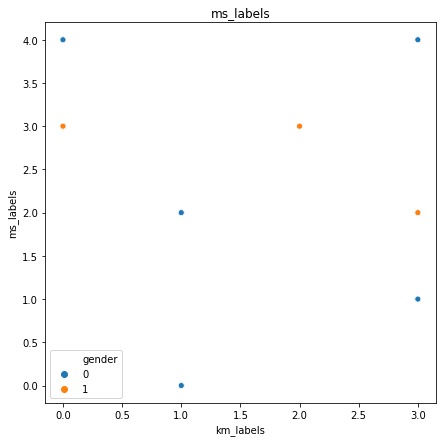

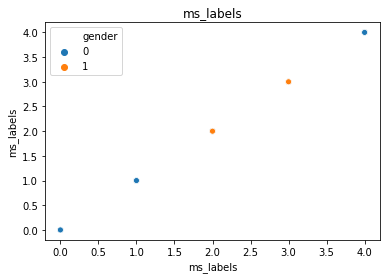

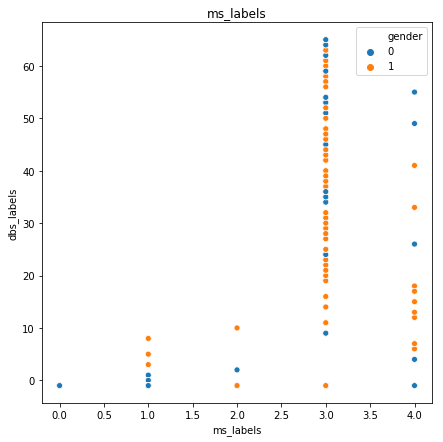

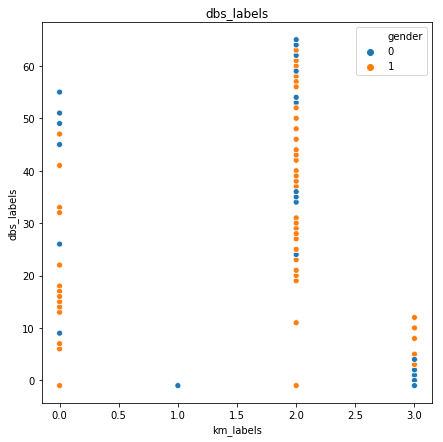

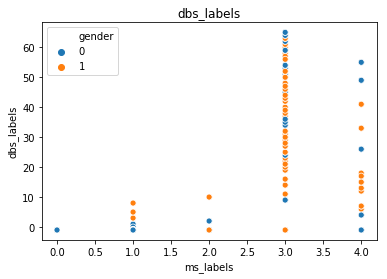

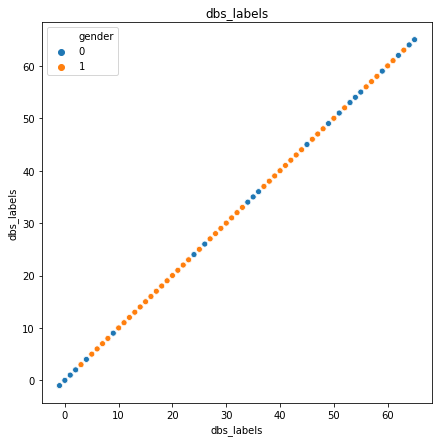

In [39]:
for col in data_numeric.columns:
  plt.figure(figsize=(7,7))
  sns.scatterplot(x =data_numeric.km_labels, y = data_numeric[col], hue = 'gender', data = data_numeric)
  plt.title(col)
  plt.show()
  sns.scatterplot(x =data_numeric.ms_labels, y = data_numeric[col], hue = 'gender', data = data_numeric)
  plt.title(col)
  plt.show()
  plt.figure(figsize=(7,7))
  sns.scatterplot(y =data_numeric.dbs_labels, x = data_numeric[col], hue = 'gender', data = data_numeric)
  plt.title(col)
  plt.show()

In [40]:
data_numeric.groupby('km_labels').size()

km_labels
0    7897
1    7951
2    7879
3    7922
dtype: int64

In [0]:
from sklearn.metrics import silhouette_score
sse = {}
silhouettes = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(data_scaled)
    labels = kmeans.labels_
    sse[k] = kmeans.inertia_
    silhouettes[k] = silhouette_score(data_numeric, labels, metric='euclidean')

In [0]:
#from sklearn.metrics import silhouette_score
#silhouettes_dbs = {}
#for k in range(1, 32):
    #dbs = DBSCAN(eps=(k/16), metric= 'euclidean', min_samples=2).fit(data_scaled)
    #labels = dbs.labels_
    #sse[k] = DBSCAN.get_params
    #silhouettes_dbs[(k/16)] = silhouette_score(data_scaled, labels, metric='euclidean')

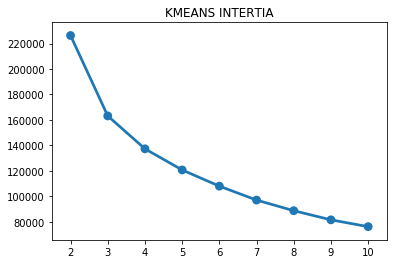

In [43]:
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.title('KMEANS INTERTIA')
plt.show()

In [44]:
sse


{2: 226287.3714657492,
 3: 163128.20841256695,
 4: 137279.8407362911,
 5: 120683.32400923106,
 6: 107955.5314972847,
 7: 97019.84742971265,
 8: 88679.66958531454,
 9: 81494.03735435422,
 10: 76146.912655928}

In [45]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

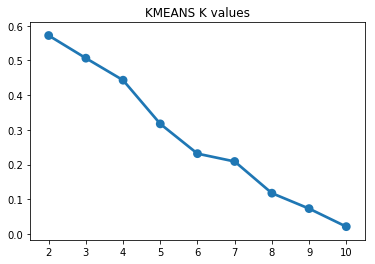

In [46]:
sns.pointplot(x=list(silhouettes.keys()), y=list(silhouettes.values()))
plt.title('KMEANS K values')
plt.show() 

In [47]:
silhouettes

{2: 0.5719801830166629,
 3: 0.5066587248548791,
 4: 0.4431880056334108,
 5: 0.3172857085481596,
 6: 0.23146152580469445,
 7: 0.2088771190016655,
 8: 0.11752319460853472,
 9: 0.07303867162083012,
 10: 0.021060203226028505}

In [0]:
#set(dbs.labels_)

In [49]:
#sns.pointplot(x=list(silhouettes_dbs.keys()), y=list(silhouettes_dbs.values()))

#plt.show()

NameError: ignored

In [0]:
#silhouettes_dbs

In [52]:
km_labels = km.labels_
n_clusters = 4
silhouette = silhouette_score(data_numeric, km_labels, metric='euclidean')
print(' KMEAN  K: {}, silhouette: {}'.format(n_clusters, silhouette))

 KMEAN  K: 4, silhouette: 0.5718232701188658


In [53]:
ms_labels = ms.labels_
n_clusters = len(np.unique(ms_labels))
silhouette = silhouette_score(data_numeric, ms_labels, metric='euclidean')
print(' MEAN SHIFT K: {}, silhouette: {}'.format(n_clusters, silhouette))

 MEAN SHIFT K: 5, silhouette: 0.5307181993524445


In [54]:
dbs_labels = dbs.labels_
n_clusters = len(np.unique(dbs_labels))
silhouette = silhouette_score(data_numeric, dbs_labels, metric='euclidean')
print('DBSCAN K: {}, silhouette: {}'.format(n_clusters, silhouette))

DBSCAN K: 67, silhouette: -0.8774111901403183


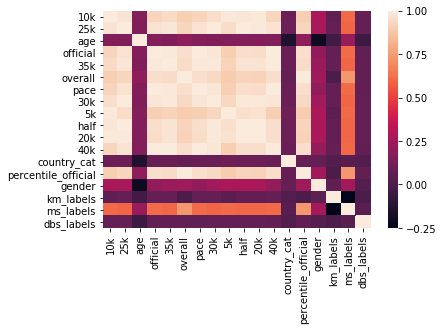

In [55]:
corr = data_numeric.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)